# 1. Implementation of the Dataset and Preparation

In [6]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
import pickle
import matplotlib.pyplot as plt
import os

# read dataset
df = pd.read_csv("ALLFLOWMETER_HIKARI2021.csv")

## Label Distribution of the Dataset

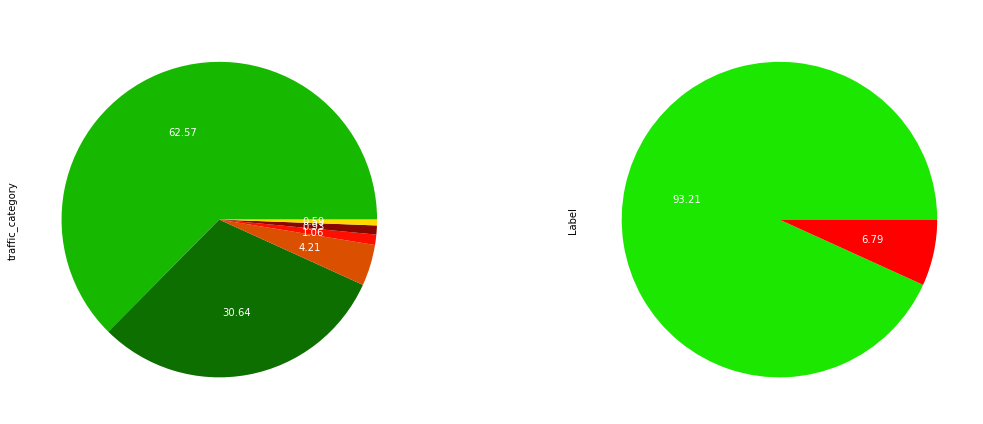

In [7]:
labels = df[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#0D6F00", "#DA4F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution",
                                             colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution",
                                               colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 



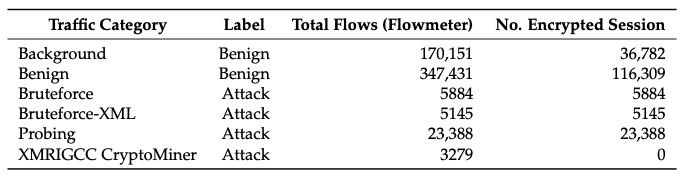

# Support Vector Machines Classification - Resampling

## Calculate the percentage distribution for the resampling

In [5]:
# Get the number of samples
samples_counter = labels['traffic_category'].count()
single_samples_counter = dict(labels['traffic_category'].value_counts())
non_mal_samples_counter = single_samples_counter['Benign'] + single_samples_counter['Background']
mal_samples_counter = single_samples_counter['Bruteforce'] + single_samples_counter['Bruteforce-XML'] + single_samples_counter['Probing'] + single_samples_counter['XMRIGCC CryptoMiner']
print('Number of samples:')
print('\t', end='')
print(samples_counter, non_mal_samples_counter, mal_samples_counter)

# Get the percentage distribution of the traffic in non-malicious & malicious
non_mal_percentage = round(non_mal_samples_counter/samples_counter * 100, 2)
mal_percentage = 100 - non_mal_percentage
print('Number of samples - percentage:')
print('\t', end='')
print(non_mal_percentage, mal_percentage)

# Get the percentage distribution of the non-malicious traffic
benign_percentage = round(single_samples_counter['Benign'] / non_mal_samples_counter * 100, 2)
background_percentage = 100 - benign_percentage
print('Number of samples - percentage for non-malicious traffic:')
print('\t', end='')
print(benign_percentage, background_percentage)

# Get the percentage distribution of the malicious traffic
bruteforce_percentage = round(single_samples_counter['Bruteforce'] / mal_samples_counter * 100, 2)
bruteforce_xml_percentage = round(single_samples_counter['Bruteforce-XML'] / mal_samples_counter * 100, 2)
probing_percentage = round(single_samples_counter['Probing'] / mal_samples_counter * 100, 2)
cryptominer_percentage = round(single_samples_counter['XMRIGCC CryptoMiner'] / mal_samples_counter * 100, 2)
print('Number of samples - percentage for malicious traffic:')
print('\t', end='')
print(bruteforce_percentage, bruteforce_xml_percentage, probing_percentage, cryptominer_percentage)

# calculate, on which size malicious and non-malicious must be sampled
percentage16_samples_counter = int(samples_counter * 0.16)
percentage24_samples_counter = int(samples_counter * 0.24)
percentage32_samples_counter = int(samples_counter * 0.32)
print('Number of samples for 16\%, 24\% and 32\%:')
print('\t', end='')
print(percentage16_samples_counter, percentage24_samples_counter, percentage32_samples_counter)


Number of samples:
	555278 517582 37696
Number of samples - percentage:
	93.21 6.790000000000006
Number of samples - percentage for non-malicious traffic:
	67.13 32.870000000000005
Number of samples - percentage for malicious traffic:
	15.61 13.65 62.04 8.7
Number of samples for 16\%, 24\% and 32\%:
	88844 133266 177688


## Scale and Normalize the dataset

In [8]:
# Drop the unnecessary values
df_labels = df[['traffic_category', 'Label']].copy()
df_values = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'originp', 'responh', 'responp', 'traffic_category', 'Label'])

# Scaling and Normalizing
scaler = preprocessing.StandardScaler().fit(df_values)
df_scaled = pd.DataFrame(scaler.transform(df_values))

# Normalizing
df_normalized = pd.DataFrame(preprocessing.normalize(df_scaled, norm='l2'))

# concat the labels with the scaled & normalized data
df_normalized['traffic_category'] = df_labels['traffic_category']
df_normalized['Label'] = df_labels['Label']
display(df_normalized)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
0,-0.013624,-0.001375,-0.002038,-0.005206,-0.004098,-0.067045,-0.071639,-0.070916,0.017689,-0.001908,...,-0.037785,-0.041995,-0.016773,-0.041536,-0.021669,0.188162,0.295889,-0.080253,Bruteforce-XML,1
1,0.011413,-0.001294,-0.001918,-0.004900,-0.003858,-0.063322,-0.067652,-0.066974,0.016650,-0.001546,...,0.120763,0.081753,0.013351,0.108173,-0.020396,0.177110,0.278511,-0.075540,Bruteforce-XML,1
2,0.005231,-0.001690,-0.002309,-0.004898,-0.004250,-0.063290,-0.067619,-0.066940,0.014933,-0.002129,...,0.086343,0.055054,0.006939,0.075750,-0.020388,0.177041,0.278402,-0.075510,Bruteforce-XML,1
3,0.001256,-0.001713,-0.002341,-0.004965,-0.004308,-0.064146,-0.068533,-0.067845,0.015137,-0.002158,...,0.064718,0.038114,0.002783,0.055301,-0.020667,0.179460,0.282206,-0.076542,Bruteforce-XML,1
4,-0.002823,-0.001731,-0.001965,-0.005019,-0.004354,-0.064822,-0.069251,-0.068558,0.041590,-0.002181,...,0.042312,0.020601,-0.001493,0.034133,-0.020889,0.181393,0.285246,-0.077367,Bruteforce-XML,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555273,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555274,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555275,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555276,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1


## Split the dataset into a training and test set

In [11]:
# Split the dataset
# --> df_train is the data, which will be resampled
# --> y_train are the labels for the test data, which will be adapted/changed to the label of the resized test set
# --> x_test and y_test are only used for the testing
df_train, x_test, y_train, y_test = train_test_split(df_normalized, labels['Label'], test_size=0.2)
print("Training set shape: " + str(df_train.shape))
print("Test set shape: " + str(x_test.shape))

# Drop any identifier (labels) from the test dataset
x_test = x_test.drop(columns=['traffic_category', 'Label'])

Training set shape: (444222, 81)
Test set shape: (111056, 81)


## Resample the traffic categories to 16%

16\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:
	59640 29203 13868 12127 55118 7729


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
428280,-0.027433,-0.010549,-0.010836,-0.024406,-0.008887,-0.098804,-0.105414,-0.104430,0.066440,-0.010587,...,-0.058191,-0.064674,-0.025831,-0.063968,-0.033371,-0.295823,-0.216786,-0.123594,Benign,0
246037,-0.027332,-0.010510,-0.010796,-0.024316,-0.008854,-0.098468,-0.105056,-0.104075,0.066197,-0.010548,...,-0.057978,-0.064437,-0.025736,-0.063733,-0.033249,-0.294738,-0.215992,-0.123141,Benign,0
471343,-0.026772,-0.010928,-0.011201,-0.027816,-0.009301,-0.098817,-0.105502,-0.104480,0.064839,-0.010465,...,-0.056788,-0.063115,-0.025208,-0.062426,-0.032567,-0.288693,-0.211561,-0.120615,Benign,0
401676,-0.020684,-0.004156,-0.002434,-0.015748,-0.003896,-0.078723,-0.083326,-0.082882,0.233894,-0.004079,...,-0.045123,-0.050150,-0.020030,-0.049602,-0.025877,0.224701,0.353348,-0.087365,Benign,0
216027,-0.020696,-0.004432,-0.005777,-0.013403,-0.007347,-0.085108,-0.091039,-0.090070,-0.042294,-0.004349,...,-0.048110,-0.053470,-0.021356,-0.052886,-0.027590,0.239576,0.379939,-0.100744,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553961,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424590,-0.008507,...,-0.047374,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100619,XMRIGCC CryptoMiner,1
554981,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047374,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
552687,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
552435,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1


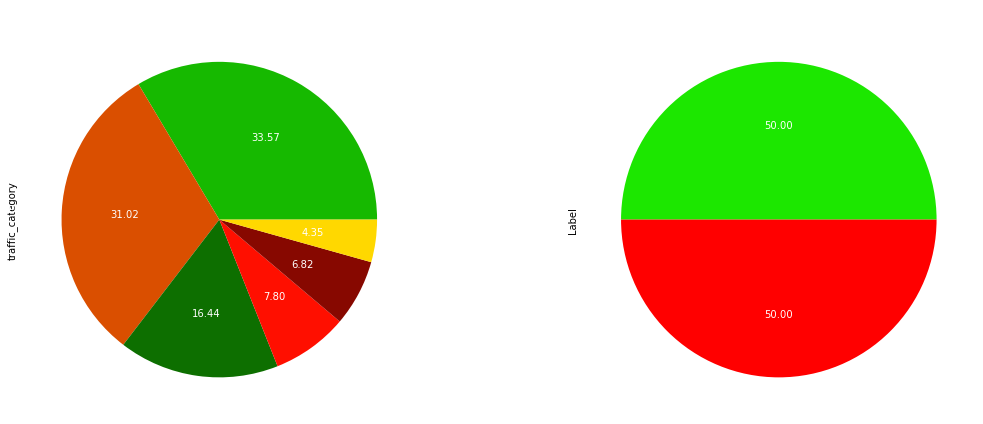

In [14]:
# Get the number of samples, every subset must be down-/upsampled
benign_sample_number = int(percentage16_samples_counter * (benign_percentage / 100))
background_sample_number = int(percentage16_samples_counter * (background_percentage / 100))
bruteforce_sample_number = int(percentage16_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_sample_number = int(percentage16_samples_counter * (bruteforce_xml_percentage / 100))
probing_sample_number = int(percentage16_samples_counter * (probing_percentage / 100)) 
cryptominer_sample_number = int(percentage16_samples_counter * (cryptominer_percentage / 100))
print('16\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:')
print('\t', end='')
print(benign_sample_number, background_sample_number, bruteforce_sample_number, bruteforce_xml_sample_number, probing_sample_number, cryptominer_sample_number)


# Sample the dataset
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_sample_number, random_state=42)

# Concat the dataset
df_16 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_16)

# Show the new distribution
labels = df_16[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 

## Prepare the 16% test data

In [17]:
# create the label-set for the 16% training data
y_train = df_16['Label'].copy()

# create a test set with the 16% values and without any identifier/lable
x_train = df_16.drop(columns=['traffic_category', 'Label'])

print("16% Training set shape:" + str(x_train.shape))
print("Test set shape:" + str(x_test.shape))

16% Training set shape:(177685, 79)
Test set shape:(111056, 79)


## Create a SVC Model with 16% resampled data

In [ ]:
if not os.path.exists('svc_models/traffic_analysis_16_balance_svc.model'):
    clf_16_balancing = SVC(gamma='auto')
    clf_16_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_16_balance_svc.model', 'wb') as handle:
        pickle.dump(clf_16_balancing, handle)

## Test the 16% SVC Model

In [ ]:
# Load SVC Model from the previous step
with open('svc_models/traffic_analysis_16_balance_svc.model', 'rb') as handle:
    clf_16_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_16_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    103497
           1       0.26      0.90      0.40      7559

    accuracy                           0.82    111056
   macro avg       0.62      0.85      0.64    111056
weighted avg       0.94      0.82      0.86    111056



## Resample the traffic categories to 24%

24\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:
	89461 43804 20802 18190 82678 11594


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
428280,-0.027433,-0.010549,-0.010836,-0.024406,-0.008887,-0.098804,-0.105414,-0.104430,0.066440,-0.010587,...,-0.058191,-0.064674,-0.025831,-0.063968,-0.033371,-0.295823,-0.216786,-0.123594,Benign,0
246037,-0.027332,-0.010510,-0.010796,-0.024316,-0.008854,-0.098468,-0.105056,-0.104075,0.066197,-0.010548,...,-0.057978,-0.064437,-0.025736,-0.063733,-0.033249,-0.294738,-0.215992,-0.123141,Benign,0
471343,-0.026772,-0.010928,-0.011201,-0.027816,-0.009301,-0.098817,-0.105502,-0.104480,0.064839,-0.010465,...,-0.056788,-0.063115,-0.025208,-0.062426,-0.032567,-0.288693,-0.211561,-0.120615,Benign,0
401676,-0.020684,-0.004156,-0.002434,-0.015748,-0.003896,-0.078723,-0.083326,-0.082882,0.233894,-0.004079,...,-0.045123,-0.050150,-0.020030,-0.049602,-0.025877,0.224701,0.353348,-0.087365,Benign,0
216027,-0.020696,-0.004432,-0.005777,-0.013403,-0.007347,-0.085108,-0.091039,-0.090070,-0.042294,-0.004349,...,-0.048110,-0.053470,-0.021356,-0.052886,-0.027590,0.239576,0.379939,-0.100744,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552565,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
554773,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553144,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
554740,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1


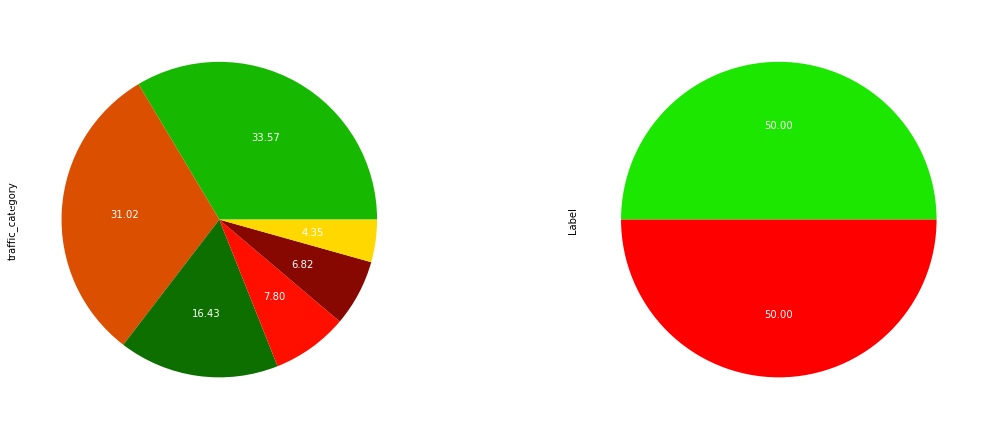

In [16]:
# Get the number of samples, every subset must be down-/upsampled
benign_24_sample_number = int(percentage24_samples_counter * (benign_percentage / 100))
background_24_sample_number = int(percentage24_samples_counter * (background_percentage / 100))
bruteforce_24_sample_number = int(percentage24_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_24_sample_number = int(percentage24_samples_counter * (bruteforce_xml_percentage / 100))
probing_24_sample_number = int(percentage24_samples_counter * (probing_percentage / 100)) 
cryptominer_24_sample_number = int(percentage24_samples_counter * (cryptominer_percentage / 100))
print('24\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:')
print('\t', end='')
print(benign_24_sample_number, background_24_sample_number, bruteforce_24_sample_number, bruteforce_xml_24_sample_number, probing_24_sample_number, cryptominer_24_sample_number)


# Sample the dataset
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_24_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_24_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_24_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_24_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_24_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_24_sample_number, random_state=42)

# Concat the dataset
df_24 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_24)

# Show the new distribution
labels = df_24[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 

## Prepare the test data

In [18]:
# create the label-set for the 24% training data
y_train = df_24['Label'].copy()

# create a test set with the 24% values and without any identifier/lable
x_train = df_24.drop(columns=['traffic_category', 'Label'])

print("24% Training set shape:" + str(x_train.shape))
print("General Test set shape:" + str(x_test.shape))

24% Training set shape:(266529, 79)
General Test set shape:(111056, 79)


## Create a SVC Model with 24% resampled data

In [ ]:
if not os.path.exists('svc_models/traffic_analysis_24_balance_svc.model'):
    clf_24_balancing = SVC(gamma='auto')
    clf_24_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_24_balance_svc.model', 'wb') as handle:
        pickle.dump(clf_24_balancing, handle)

## Test the 24% SVC Model

In [ ]:
# Load SVC Model from the previous step
with open('svc_models/traffic_analysis_24_balance_svc.model', 'rb') as handle:
    clf_24_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_24_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    103497
           1       0.26      0.90      0.40      7559

    accuracy                           0.82    111056
   macro avg       0.63      0.86      0.65    111056
weighted avg       0.94      0.82      0.86    111056



## Resample the traffic categories to 32%

32\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:
	119281 58406 27737 24254 110237 15458


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
428280,-0.027433,-0.010549,-0.010836,-0.024406,-0.008887,-0.098804,-0.105414,-0.104430,0.066440,-0.010587,...,-0.058191,-0.064674,-0.025831,-0.063968,-0.033371,-0.295823,-0.216786,-0.123594,Benign,0
246037,-0.027332,-0.010510,-0.010796,-0.024316,-0.008854,-0.098468,-0.105056,-0.104075,0.066197,-0.010548,...,-0.057978,-0.064437,-0.025736,-0.063733,-0.033249,-0.294738,-0.215992,-0.123141,Benign,0
471343,-0.026772,-0.010928,-0.011201,-0.027816,-0.009301,-0.098817,-0.105502,-0.104480,0.064839,-0.010465,...,-0.056788,-0.063115,-0.025208,-0.062426,-0.032567,-0.288693,-0.211561,-0.120615,Benign,0
401676,-0.020684,-0.004156,-0.002434,-0.015748,-0.003896,-0.078723,-0.083326,-0.082882,0.233894,-0.004079,...,-0.045123,-0.050150,-0.020030,-0.049602,-0.025877,0.224701,0.353348,-0.087365,Benign,0
216027,-0.020696,-0.004432,-0.005777,-0.013403,-0.007347,-0.085108,-0.091039,-0.090070,-0.042294,-0.004349,...,-0.048110,-0.053470,-0.021356,-0.052886,-0.027590,0.239576,0.379939,-0.100744,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552926,-0.018716,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424590,-0.008507,...,-0.047374,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100619,XMRIGCC CryptoMiner,1
554042,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
554683,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
552711,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047374,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1


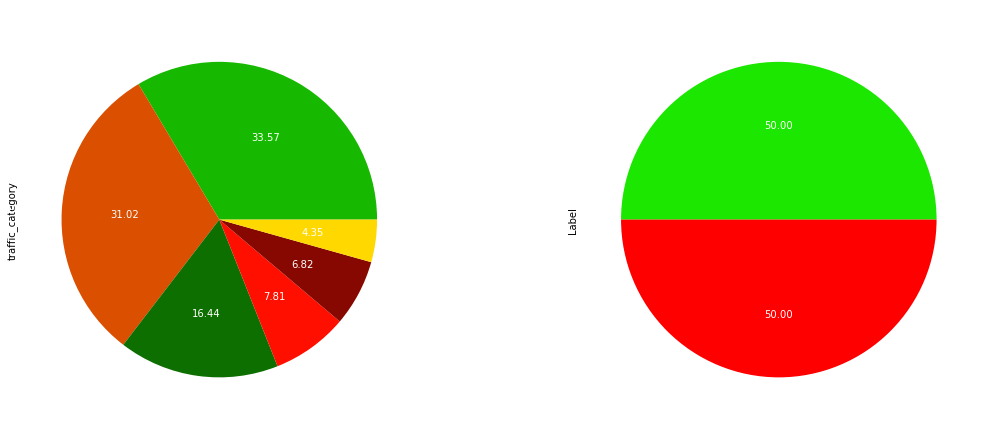

In [20]:
# Get the number of samples, every subset must be down-/upsampled
benign_32_sample_number = int(percentage32_samples_counter * (benign_percentage / 100))
background_32_sample_number = int(percentage32_samples_counter * (background_percentage / 100))
bruteforce_32_sample_number = int(percentage32_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_32_sample_number = int(percentage32_samples_counter * (bruteforce_xml_percentage / 100))
probing_32_sample_number = int(percentage32_samples_counter * (probing_percentage / 100)) 
cryptominer_32_sample_number = int(percentage32_samples_counter * (cryptominer_percentage / 100))
print('32\% of samples for benign, background, bruteforce, bruteforce-xml, probing and the cryptominer:')
print('\t', end='')
print(benign_32_sample_number, background_32_sample_number, bruteforce_32_sample_number, bruteforce_xml_32_sample_number, probing_32_sample_number, cryptominer_32_sample_number)


# Sample the dataset
from sklearn.utils import resample
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_32_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_32_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_32_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_32_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_32_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_32_sample_number, random_state=42)

# Concat the dataset
df_32 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_32)

# Show the new distribution
labels = df_32[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 

## Prepare the test data

In [21]:
# create the label-set for the 32% training data
y_train = df_32['Label'].copy()
y_train_traffic_category = df_32['traffic_category'].copy()

# create a test set with the 32% values and without any identifier/lable
x_train = df_32.drop(columns=['traffic_category', 'Label'])

print("32% Training set shape:" + str(x_train.shape))
print("Test set shape:" + str(x_test.shape))

Training set shape:(355373, 79)
Test set shape:(111056, 79)


# Save 32% dataset for the PyTorch data

In [12]:
# create a dictiornary with the 32% dataset (test and train data)
coder = OneHotEncoder(sparse=False)

y_train_out = coder.fit_transform(y_train.to_numpy().reshape(len(y_train), 1))
y_test_out = coder.fit_transform(y_test.to_numpy().reshape(len(y_test), 1))
pytorch_data = [x_train, x_test, y_train_out, y_test_out]

y_train_out_traffic_category = coder.fit_transform(y_train_traffic_category.to_numpy().reshape(len(y_train_traffic_category), 1))
y_test_out_traffic_category = coder.fit_transform(y_test_category.to_numpy().reshape(len(y_test_category), 1))
pytorch_data_traffic_category = [x_train, x_test, y_train_out_traffic_category, y_test_out_traffic_category]

# save/export the dictionary
with open("pytorch/resampled_32.pickle", 'wb') as handle:
        pickle.dump(pytorch_data, handle)

# save/export the dictionary
with open("pytorch/resampled_32_traffic_category.pickle", 'wb') as handle:
        pickle.dump(pytorch_data_traffic_category, handle)

## Create a SVC Model with 32% resampled data

In [ ]:
if not os.path.exists('svc_models/traffic_analysis_32_balance_svc.model'):
    clf_32_balancing = SVC(gamma='auto')
    clf_32_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_32_balance_svc.model', 'wb') as handle:
        pickle.dump(clf_32_balancing, handle)

## Test the 32% SVC Model

In [ ]:
with open('svc_models/traffic_analysis_32_balance_svc.model', 'rb') as handle:
    clf_32_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_32_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    103497
           1       0.27      0.99      0.43      7559

    accuracy                           0.82    111056
   macro avg       0.64      0.90      0.66    111056
weighted avg       0.95      0.82      0.86    111056



# Create a SVC Model with the non-malicious data downsampled to the size of the malicious data 

## Resample the the non-malicious traffic categories

Train set distribution:
{'Benign': 20326, 'Probing': 18801, 'Background': 9952, 'Bruteforce': 4705, 'Bruteforce-XML': 4131, 'XMRIGCC CryptoMiner': 2642}
Malicious traffic counter: 30279
New size of benign traffic: 20326
New size of background traffic: 9952
Shape benign traffic: (277801, 81)
Shape background traffic: (136142, 81)
New shape benign traffic: (20326, 81)
New shape background traffic: (9952, 81)
New train set distribution:
{'Benign': 20326, 'Probing': 18801, 'Background': 9952, 'Bruteforce': 4705, 'Bruteforce-XML': 4131, 'XMRIGCC CryptoMiner': 2642}


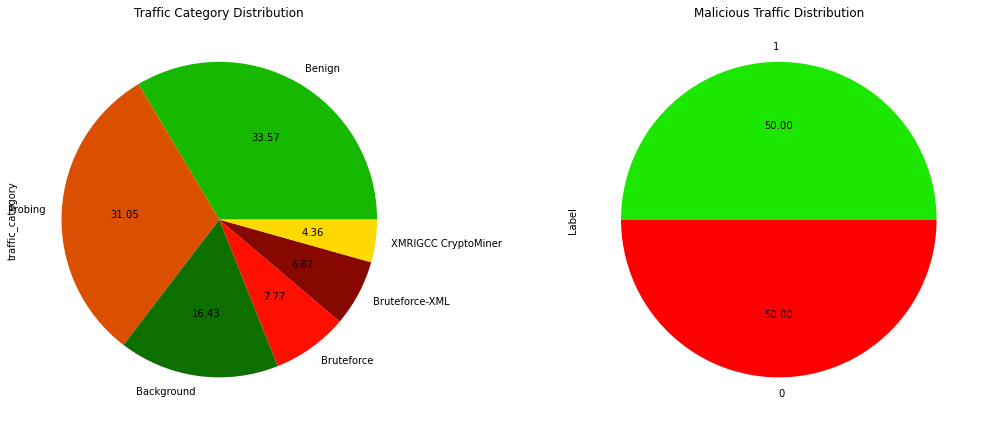

In [ ]:
# Size of all malicious traffic categories
train_set_counter = dict(labels['traffic_category'].value_counts())
mal_traffic_counter = train_set_counter['Probing'] + train_set_counter['Bruteforce'] + train_set_counter['Bruteforce-XML'] + train_set_counter['XMRIGCC CryptoMiner']
print("Train set distribution:")
print(train_set_counter)
print("Malicious traffic counter: " + str(mal_traffic_counter))

# calculate the size of the new non-malicious dataset
new_benign_size = int(mal_traffic_counter * (benign_percentage / 100))
new_background_size = int(mal_traffic_counter * (background_percentage / 100))
print("New size of benign traffic: " + str(new_benign_size))
print("New size of background traffic: " + str(new_background_size))

# split benign and background from the training set
benign_training = df_train[df_train['traffic_category'] == "Benign"]
background_training = bening_entries = df_train[df_train['traffic_category'] == "Background"]
print("Shape benign traffic: " + str(benign_training.shape))
print("Shape background traffic: " + str(background_training.shape))
malicious_traffic_set = df_train[df_train['Label'] == 1]

# resample the non-malicious traffic
new_benign_traffic = resample(benign_training, n_samples=new_benign_size)
new_background_traffic = resample(background_training, n_samples=new_background_size)
print("New shape benign traffic: " + str(new_benign_traffic.shape))
print("New shape background traffic: " + str(new_background_traffic.shape))

# recreate the training set by merging the resampled non-malicious 
df_non_mal_downsample = pd.concat([new_benign_traffic, new_background_traffic, malicious_traffic_set])
new_train_set_counter = dict(df_non_mal_downsample['traffic_category'].value_counts())
print("New train set distribution:")
print(new_train_set_counter)

# Show the new distribution
downsampled_labels = df_non_mal_downsample[['traffic_category', 'Label']].copy()
traffic_distribution = downsampled_labels['traffic_category']
malicious_distribution= downsampled_labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.rcParams['text.color'] = 'white'
plt.tight_layout() 


## Prepare the test data

In [ ]:
# create a test set with the labels
y_train = df_non_mal_downsample['Label'].copy()

# create a test set with the values and without any identifier
x_train = df_non_mal_downsample.drop(columns=['traffic_category', 'Label'])

print("Training values set shape:" + str(x_train.shape))
print("Training label set shape:" + str(y_train.shape))
print("Test set shape:" + str(x_test.shape))

Training values set shape:(60557, 79)
Training label set shape:(60557,)
Test set shape:(111056, 79)


## Create a SVC Model with the downsampled non-malicious traffic

In [ ]:
if not os.path.exists('svc_models/traffic_analysis_downsampled_non-mal_svc.model'):
    clf_downsample_balancing = SVC(gamma='auto')
    clf_downsample_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_downsampled_non-mal_svc.model', 'wb') as handle:
        pickle.dump(clf_downsample_balancing, handle)

## Test the downsampled non-malicious SVC Model

In [ ]:
with open('svc_models/traffic_analysis_downsampled_non-mal_svc.model', 'rb') as handle:
    clf_downsample_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_downsample_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.80      0.89    103639
           1       0.25      0.91      0.39      7417

    accuracy                           0.81    111056
   macro avg       0.62      0.86      0.64    111056
weighted avg       0.94      0.81      0.86    111056



## Create a SVC Model with the downsampled non-malicious traffic and identify the traffic category

In [ ]:
# create a test set with the labels
y_train = df_non_mal_downsample['traffic_category'].copy()

# create a test set with the values and without any identifier
x_train = df_non_mal_downsample.drop(columns=['traffic_category', 'Label'])

print("Training values set shape:" + str(x_train.shape))
print("Training label set shape:" + str(y_train.shape))
print("Test set shape:" + str(x_test.shape))

Training values set shape:(60557, 79)
Training label set shape:(60557,)
Test set shape:(111056, 79)


In [ ]:
if not os.path.exists('svc_models/traffic_category_downsampled_non-mal_svc.model'):
    clf_category_downsample_balancing = SVC(gamma='auto')
    clf_category_downsample_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_category_downsampled_non-mal_svc.model', 'wb') as handle:
        pickle.dump(clf_category_downsample_balancing, handle)

## Test the traffic category with the downsampled non-malicious SVC Model

In [ ]:
with open('svc_models/traffic_category_downsampled_non-mal_svc.model', 'rb') as handle:
    clf_category_downsample_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_category_downsample_balancing.predict(x_test_category)
print(classification_report(y_test_category, pred_labels))

                     precision    recall  f1-score   support

         Background       0.66      0.36      0.47     34326
             Benign       0.74      0.62      0.67     69295
         Bruteforce       0.20      1.00      0.34      1192
     Bruteforce-XML       0.37      1.00      0.54      1021
            Probing       0.27      0.99      0.42      4574
XMRIGCC CryptoMiner       0.07      0.98      0.13       648

           accuracy                           0.56    111056
          macro avg       0.38      0.82      0.43    111056
       weighted avg       0.68      0.56      0.59    111056

